# Table of contents
1. [Setup](#setup)
2. [OPTIONAL Visualize the data](#viz)
3. [Use Case 1: Check and tag suspicious transactions](#usecase1)
4. [Use Case 2: Process a new transaction](#usecase2)
5. [Use Case 3: Match suspicious customers locally with an SDN list](#usecase3)
 

## Setup environment variables for the notebook <a name="setup"></a>
In the next few statements, the environment and graph related context is initialized.

In [252]:
######## setup variables ##########
gs_prefix="gs://anand-31-simple-files/aml-customer-extended"
cluster_name="katana-internal31"
partitions = 1
platform_prefix=gs_prefix

In [253]:
import os                                                                        
import time                                                                      
import json
import pandas as pd
from timeit import default_timer as timer
from katana.remote import aio, analytics, import_data, trace

from katana import remote
from katana.remote import import_data

import dask.dataframe as dd
import matplotlib.pyplot as plt
os.environ["KATANA_SERVER_ADDRESS"] = "host.docker.internal:8080"

pd.set_option('display.max_columns', None)
pd.set_option("max_colwidth", None)

In [254]:
from diagrams import Cluster, Diagram
from diagrams.gcp.analytics import BigQuery, Dataflow, PubSub
from diagrams.gcp.compute import AppEngine, Functions
from diagrams.gcp.database import BigTable
from diagrams.gcp.iot import IotCore
from diagrams.gcp.storage import GCS
from diagrams.programming import flowchart
from diagrams.programming import language
from diagrams.custom import Custom

### <b>Instantiate the client</b>

In [255]:
rc=remote.Client()
rc.server_version

'0.1.101rc1.dev+26.5.fecc99.6020d8'

### <b> Pick a particular graph </b>

In [256]:
graph=None
for g in rc.graphs():
    print(g.graph_id)
    if(g.graph_id == 'CGR2Z5e23vtKCgZKqgLrNyXrox1BfzzMLzkqs9iCRAvs'):
        graph=g


24P9VG9EghucM3mqG23Rx3dPPPxtivXCBiaDMoypD2n9
72jaN4snisfRJdwqbPMcguFutz8Pq4iRRifJUqkbx8xE
9NA63vT1dFnjmvYbAo1QCbPwzAKE6fFfYV9Yve7P37wT
ATEH4CNt2CJ1TSErGhra34vqfFgUWi6NQE9CFrzpBeio
CGR2Z5e23vtKCgZKqgLrNyXrox1BfzzMLzkqs9iCRAvs
DpiQPEX3u3fGdHo1WdokhgzTbV6ymyfenFwSr2i6dNt8
EGY1shsBsHGnEotW3fWUq7RFv5XhRiCU218SY3gDq6hx


In [257]:
%%time
graph.num_nodes()

          0/? [?op/s]

CPU times: user 61.9 ms, sys: 22.4 ms, total: 84.2 ms
Wall time: 5.86 s


157927

## OPTIONAL: Visualize the data <a name="viz"></a>
Use the next few statements to visualize and understand the data loaded.

In [258]:
%%time
query1="""MATCH (r:ACCOUNT{ACCOUNT_ID:'926'})<-[:TRANSACTION_RECEIVER]-(t:TRANSACTION)<-[:TRANSACTION_SENDER]-(s:ACCOUNT)-[:HAS_CUSTOMER]->(c:CUSTOMER)-[]->(ca) where s.ACCOUNT_ID in ['410'] 
       return r,s,t,c,ca"""

result = graph.query(query1, contextualize=True)
result.visualize()

          0/? [?op/s]

          0/? [?op/s]

CPU times: user 201 ms, sys: 67.5 ms, total: 268 ms
Wall time: 18.2 s


GraphVizWidget(edges=[{'from': 5951, 'to': 926, 'label': 'TRANSACTION_RECEIVER', 'type': 'TRANSACTION_RECEIVER…

### <b> Query and visualize an Alert </b>

In [ ]:
%%time
#check transaction objects
query1="""MATCH (a:ALERT{ALERT_ID:'14'})<-[ax:HAS_ALERT]-(tx:TRANSACTION) 
          WITH a, ax, tx
          MATCH (s:ACCOUNT)-[:TRANSACTION_SENDER]->(tx)-[:TRANSACTION_RECEIVER]->(r:ACCOUNT)
          RETURN s,r,a,ax,tx"""
result = graph.query(query1, contextualize=True)
result.visualize()

### <b> Check a recent transaction </b>

In [ ]:
%%time
query1="""MATCH (a)-[:TRANSACTION_SENDER]->(t:TRANSACTION{TX_ID:'200001'})-[:TRANSACTION_RECEIVER]->(b) 
        return  a,t,b"""

result = graph.query(query1)
result.to_pandas()

## Use Case 1: Detect and flag a suspicious transaction <a name="usecase1"></a>

### Check for transactions that fly under an individual limit of 10000 USD, but average over 9000 USD over 6 or more transactions 

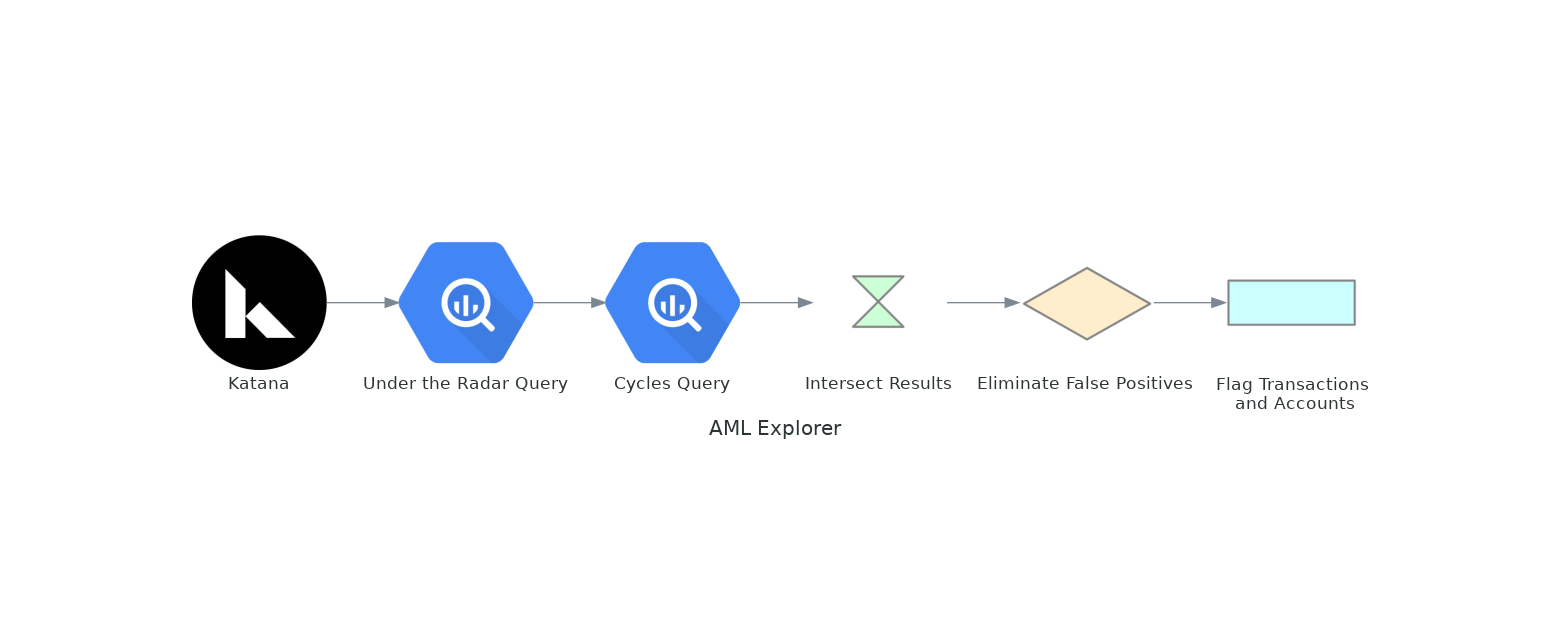

In [259]:
with Diagram("AML Explorer", show=False) as amlExplorerDiagram:
    database = Custom("Katana", "./res/katana.png")
    radar = BigQuery("Under the Radar Query")
    cycles = BigQuery("Cycles Query")
    union = flowchart.Collate("Intersect Results")
    fp = flowchart.Decision("Eliminate False Positives")
    alert = flowchart.Action("Flag Transactions\n and Accounts")
    database >> radar >> cycles >> union >> fp >> alert

amlExplorerDiagram

In [260]:
%%time
query1="""MATCH (a:ACCOUNT)-[:TRANSACTION_SENDER]->(t:TRANSACTION)-[:TRANSACTION_RECEIVER]->(b:ACCOUNT) 
            where t.dot > date('2018-01-01') and t.dot < date('2022-01-01')
              and t.TX_AMOUNT < 10000
        WITH  collect(t.TX_ID) as txs, avg(t.TX_AMOUNT) as average, count(t) as count, a.ACCOUNT_ID as sender,b.ACCOUNT_ID as receiver 
        where average > 9000 
        and count > 5  
        return  txs, average, count, sender, receiver order by count desc"""

result = graph.query(query1)
df=result.to_pandas()

          0/? [?op/s]

CPU times: user 81.7 ms, sys: 29.3 ms, total: 111 ms
Wall time: 6.7 s


In [261]:
df

,average,count,receiver,sender,txs
0,9025.000000,49,324,256,"[200001, 200002, 200003, 200004, 200005, 200006, 200007, 200008, 200009, 200010, 200011, 200012, 200013, 200014, 200015, 200016, 200017, 200018, 200019, 200020, 200021, 200022, 200023, 200024, 200025, 200026, 200027, 200028, 200029, 200030, 200031, 200032, 200033, 200034, 200035, 200036, 200037, 200038, 200039, 200040, 200041, 200042, 200043, 200044, 200045, 200046, 200047, 200048, 200049]"
1,9022.818182,33,753,919,"[210001, 210002, 210003, 210004, 210005, 210006, 210007, 210008, 210009, 210010, 210011, 210012, 210013, 210014, 210015, 210016, 210017, 210018, 210019, 210020, 210021, 210038, 210039, 210040, 210041, 210042, 210043, 210044, 210045, 210046, 210047, 210048, 210049]"


In [262]:
%%time
query1="""MATCH (a:ACCOUNT)-[:TRANSACTION_SENDER]->(t:TRANSACTION)-[:TRANSACTION_RECEIVER]->(b:ACCOUNT) 
            where t.dot > date('2018-01-01') and t.dot < date('2022-01-01')
              and t.TX_AMOUNT < 10000
        WITH  collect(t.TX_ID) as txs, avg(t.TX_AMOUNT) as average, count(t) as count, a.ACCOUNT_ID as sender,b.ACCOUNT_ID as receiver 
        where average > 510 
        and count > 5  
        return  txs, average, count, sender, receiver order by average desc limit 10"""

result = graph.query(query1)
df1=result.to_pandas()

          0/? [?op/s]

CPU times: user 90 ms, sys: 35.2 ms, total: 125 ms
Wall time: 6.43 s


<BarContainer object of 10 artists>

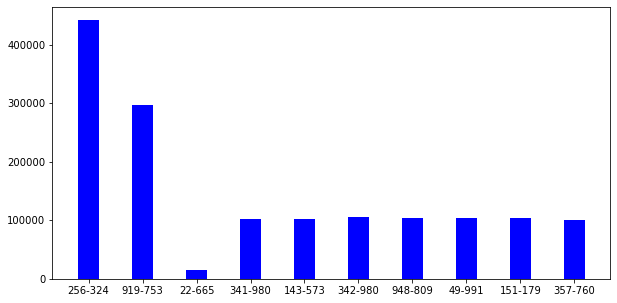

In [263]:
area = dict()

def extractArea(row):
    key = row['sender'] + str('-') + row['receiver']
    area[key]= row['average'] * row['count']
    

df1.apply(extractArea, axis=1)
partners = list(area.keys())
values = list(area.values())
plt.figure(figsize = (10, 5))
plt.bar(partners, values, color ='blue',
        width = 0.4)

Use Visualization as shown above.

### Do any of the transactions, sender or receiver match with suspicious transactions done in a cyclic pattern? 

In [264]:
%%time
query1="""MATCH (a)-[:TRANSACTION_SENDER]->(t1:TRANSACTION)-[:TRANSACTION_RECEIVER]->(b)-[:TRANSACTION_SENDER]->(t2:TRANSACTION)-[:TRANSACTION_RECEIVER]->(c)
        where t1.TX_AMOUNT = t2.TX_AMOUNT
          and NOT a.ACCOUNT_ID = b.ACCOUNT_ID
          and NOT b.ACCOUNT_ID = c.ACCOUNT_ID
        WITH a, b, c, t1,t2
        MATCH  (c)-[:TRANSACTION_SENDER]->(t3:TRANSACTION)-[:TRANSACTION_RECEIVER]->(d)
        where t3.TX_AMOUNT = t2.TX_AMOUNT
          and NOT d.ACCOUNT_ID = c.ACCOUNT_ID
        WITH a, b, c, d, t1,t2, t3
        MATCH  (d)-[:TRANSACTION_SENDER]->(t4:TRANSACTION)-[:TRANSACTION_RECEIVER]->(e)
        where t4.TX_AMOUNT = t3.TX_AMOUNT
          and NOT e.ACCOUNT_ID = d.ACCOUNT_ID
        WITH a, b, c, d, e, t1,t2, t3, t4
        MATCH  (e)-[:TRANSACTION_SENDER]->(t5:TRANSACTION)-[:TRANSACTION_RECEIVER]->(f)
        where t5.TX_AMOUNT = t4.TX_AMOUNT
          and NOT f.ACCOUNT_ID = e.ACCOUNT_ID
          and f.ACCOUNT_ID = a.ACCOUNT_ID
          and ( a.ACCOUNT_ID = '753' or b.ACCOUNT_ID = '753' or c.ACCOUNT_ID = '753' or d.ACCOUNT_ID = '753' or e.ACCOUNT_ID = '753' or f.ACCOUNT_ID = '753' )
        return a, b, c, d, e, f, t1,t2, t3, t4, t5 
        """

result = graph.query(query1, contextualize = True)
cycles=result.to_pandas()
result.visualize()

          0/? [?op/s]

          0/? [?op/s]

CPU times: user 289 ms, sys: 90.2 ms, total: 379 ms
Wall time: 28.7 s


GraphVizWidget(edges=[{'from': 119615, 'to': 98, 'label': 'TRANSACTION_RECEIVER', 'type': 'TRANSACTION_RECEIVE…

### Find the suspicious transaction that also exists in the cycle . (Ideally this should be supported in Cypher)

In [265]:
suspiciousTXSet = set()
for tx in df['txs']:
    for sus in tx:
        suspiciousTXSet.add(sus)

cycleNodeSet = set()
for cnode in cycles['t1']:
    cycleNodeSet.add(cnode['properties']['TX_ID'])
for cnode in cycles['t2']:
    cycleNodeSet.add(cnode['properties']['TX_ID'])
for cnode in cycles['t3']:
    cycleNodeSet.add(cnode['properties']['TX_ID'])
for cnode in cycles['t4']:
    cycleNodeSet.add(cnode['properties']['TX_ID'])
for cnode in cycles['t5']:
    cycleNodeSet.add(cnode['properties']['TX_ID'])

uSet=suspiciousTXSet.intersection(cycleNodeSet)
print('The transactions that occur both in the earlier detected suspcious list as well as in cycles is :')
uSet

The transactions that occur both in the earlier detected suspcious list as well as in cycles is :


{'210049'}

### Check for false positives

In [266]:
%%time
query1="""MATCH (a:ACCOUNT)-[]-(t:TRANSACTION)-[]-(b:ACCOUNT)  
        WHERE a.ACCOUNT_ID = '256'
          and not b.ACCOUNT_ID = '324'
        return avg(t.TX_AMOUNT)"""
result = graph.query(query1)
result.to_pandas()

          0/? [?op/s]

CPU times: user 67.8 ms, sys: 31.2 ms, total: 99 ms
Wall time: 6.54 s


,avg(t.TX_AMOUNT)
0,549.83


In [267]:
%%time
query1="""MATCH (a:ACCOUNT)-[]-(t:TRANSACTION)-[]-(b:ACCOUNT) 
        WHERE a.ACCOUNT_ID = '753'
          and not b.ACCOUNT_ID = '919'
        return avg(t.TX_AMOUNT)"""
result = graph.query(query1)
result.to_pandas()

          0/? [?op/s]

CPU times: user 85.7 ms, sys: 20.8 ms, total: 107 ms
Wall time: 6.47 s


,avg(t.TX_AMOUNT)
0,2.482947e+06


The average transaction amount for account <b>256</b> of the accounts is much smaller than the one for <b>753</b>. Hence the account <b>256</b> is tagged as a true positive and the transactions with account <b>256</b> associated are tagged as suspicious

### Create an alert for the transaction and mark the customer for account '256' as suspicious 

In [268]:
%%time
query1="""MATCH (t:TRANSACTION)  
        WHERE t.TX_ID = '210049'
        CREATE (t)<-[:HAS_ALERT]-(alert:ALERT{ALERT_ID:'10001', DESCRIPTION: 'High Value with cycle links'})
        return alert"""
result = graph.query(query1)
result.to_pandas()

          0/? [?op/s]

CPU times: user 381 ms, sys: 91.8 ms, total: 473 ms
Wall time: 7.41 s


,alert
0,"{'id': 157927, 'labels': ['ALERT'], 'properties': {'ALERT_ID': '10001', 'DESCRIPTION': 'High Value with cycle links'}, 'type': 'node'}"


In [269]:
%%time
query1="""MATCH (p)-[]-(t)<-[:HAS_ALERT]-(alert:ALERT{ALERT_ID:'10001'})  
        return p,t, alert"""
result = graph.query(query1, contextualize = True)
result.visualize()

          0/? [?op/s]

          0/? [?op/s]

CPU times: user 222 ms, sys: 63.9 ms, total: 286 ms
Wall time: 14.3 s


GraphVizWidget(edges=[{'from': 119613, 'to': 753, 'label': 'TRANSACTION_RECEIVER', 'type': 'TRANSACTION_RECEIV…

In [270]:
%%time
query1="""MATCH (a:ACCOUNT)-[:HAS_CUSTOMER]->(c:CUSTOMER)  
        WHERE a.ACCOUNT_ID = '256'
        SET c.SUSPICIOUS = 'true'
        return c"""
result = graph.query(query1)
result.to_pandas()

          0/? [?op/s]

CPU times: user 174 ms, sys: 40.8 ms, total: 215 ms
Wall time: 8.57 s


,c
0,"{'id': 1256, 'labels': ['CUSTOMER'], 'properties': {'CUSTOMER_ID': 'C_256', 'DOB': '1961-05-04', 'FIRSTNAME': 'CENTENO', 'LASTNAME': 'RIVERA', 'PEP': 'false', 'SUSPICIOUS': 'true'}, 'type': 'node'}"


## Use Case 2: Process a new transaction <a name="usecase2"></a>

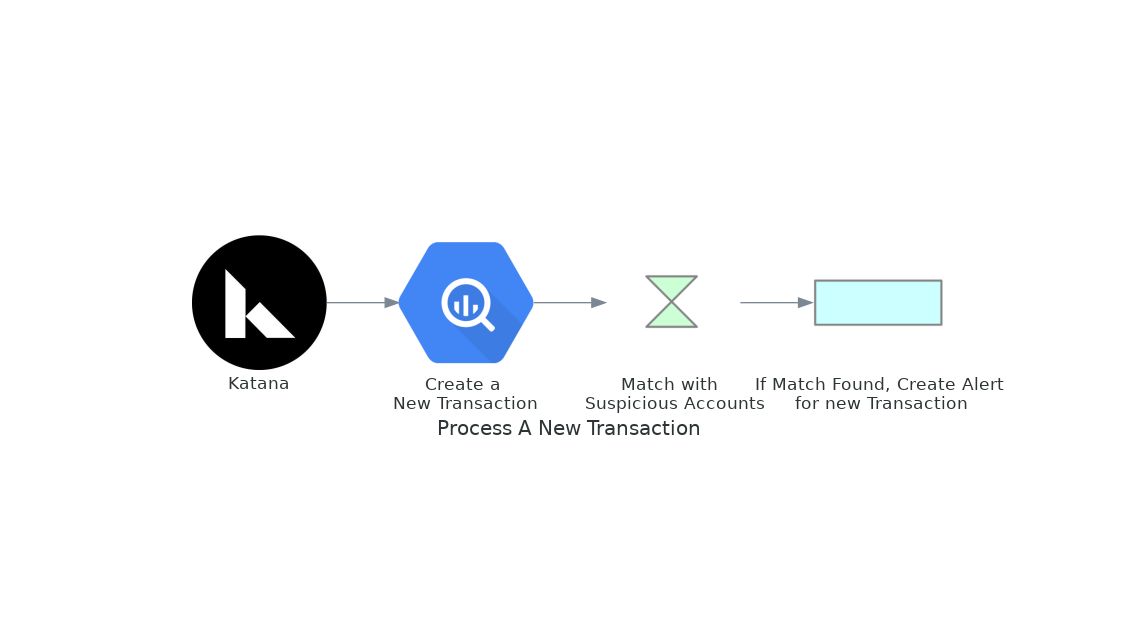

In [271]:
with Diagram("Process A New Transaction", show=False) as newTransactionDiagram:
    database = Custom("Katana", "./res/katana.png")
    newTx = BigQuery("Create a \nNew Transaction")
    match = flowchart.Collate("Match with \n Suspicious Accounts")
    alert = flowchart.Action("If Match Found, Create Alert\n for new Transaction")
    database >> newTx >> match >> alert

newTransactionDiagram

In [272]:
%%time
query1 = """MATCH (sender:ACCOUNT{ACCOUNT_ID:'125'})
WITH sender
MATCH (rec:ACCOUNT{ACCOUNT_ID: '256'})
WITH sender, rec
CREATE (sender)-[:TRANSACTION_SENDER]->(t:TRANSACTION{TX_ID: '999999',TX_AMOUNT: 6.5})-[:TRANSACTION_RECEIVER]->(rec)
RETURN t"""
result = graph.query(query1)
result.to_pandas()

          0/? [?op/s]

CPU times: user 358 ms, sys: 76.7 ms, total: 435 ms
Wall time: 15.1 s


,t
0,"{'id': 157928, 'labels': ['TRANSACTION'], 'properties': {'TX_AMOUNT': 6.5, 'TX_ID': '999999'}, 'type': 'node'}"


Check the sender and receiver of this transaction for suspicion flag

In [273]:
%%time
query1 = """MATCH (t:TRANSACTION{TX_ID:'999999'})-[]-(a:ACCOUNT)-[]-(c:CUSTOMER)
WHERE c.SUSPICIOUS = 'true'
WITH t
CREATE (t)<-[:HAS_ALERT]-(alert:ALERT{ALERT_ID:'10002', DESCRIPTION: 'Sender or Receiver is suspicious'})
return alert
"""
result = graph.query(query1)
result.to_pandas()

          0/? [?op/s]

CPU times: user 344 ms, sys: 86.9 ms, total: 431 ms
Wall time: 12.3 s


,alert
0,"{'id': 157929, 'labels': ['ALERT'], 'properties': {'ALERT_ID': '10002', 'DESCRIPTION': 'Sender or Receiver is suspicious'}, 'type': 'node'}"


In [274]:
%%time
query1="""MATCH (p)-[]-(t)<-[:HAS_ALERT]-(alert:ALERT{ALERT_ID:'10002'})  
        return p,t, alert"""
result = graph.query(query1, contextualize = True)
result.visualize()

          0/? [?op/s]

          0/? [?op/s]

CPU times: user 196 ms, sys: 57.2 ms, total: 254 ms
Wall time: 17.1 s


GraphVizWidget(edges=[{'from': 157928, 'to': 256, 'label': 'TRANSACTION_RECEIVER', 'type': 'TRANSACTION_RECEIV…

### Use Case 3: Match suspicious customers locally with an SDN list<a name="usecase3"></a>
1. Load SDN locally
2. Compare with customers and identify candidates


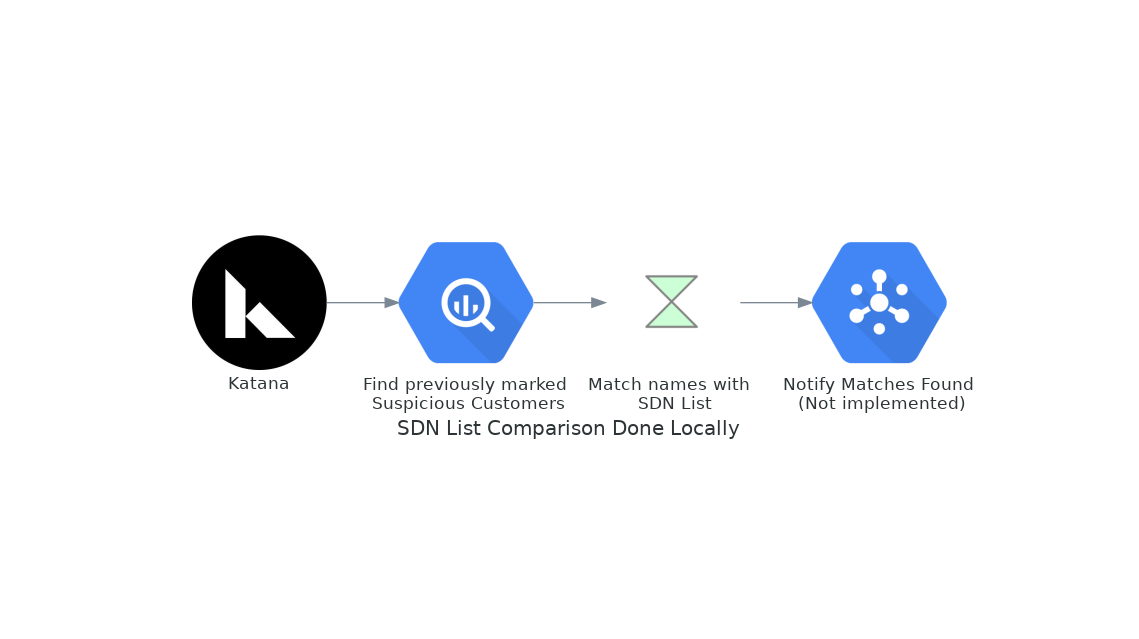

In [275]:
with Diagram("SDN List Comparison Done Locally", show=False) as LocalSDNListComparison:
    database = Custom("Katana", "./res/katana.png")
    sus = BigQuery("Find previously marked\n Suspicious Customers")
    match = flowchart.Collate("Match names with \n SDN List")
    pub = PubSub("Notify Matches Found\n (Not implemented)")
    database >> sus >> match >> pub

LocalSDNListComparison

In [276]:
sdnEntriesFile = 'gs://anand-31-simple-files/aml-customer-extended/data/sdnEntries.csv'
sdnDF = dd.read_csv(sdnEntriesFile)

In [277]:
sdnHead=sdnDF.head(5)

In [278]:
sdnHead

,UID,LASTNAME,SDNTYPE
0,36,AEROCARIBBEAN AIRLINES,Entity
1,173,"ANGLO-CARIBBEAN CO., LTD.",Entity
2,306,BANCO NACIONAL DE CUBA,Entity
3,424,BOUTIQUE LA MAISON,Entity
4,475,CASA DE CUBA,Entity


In [279]:
%%time
query1="""MATCH (c:CUSTOMER{SUSPICIOUS: 'true'})  
        return c"""
result = graph.query(query1)
susDF = result.to_pandas()
susDF

          0/? [?op/s]

CPU times: user 95.5 ms, sys: 26.6 ms, total: 122 ms
Wall time: 7.81 s


,c
0,"{'id': 1256, 'labels': ['CUSTOMER'], 'properties': {'CUSTOMER_ID': 'C_256', 'DOB': '1961-05-04', 'FIRSTNAME': 'CENTENO', 'LASTNAME': 'RIVERA', 'PEP': 'false', 'SUSPICIOUS': 'true'}, 'type': 'node'}"


In [280]:
fullName = ""
for c in susDF['c']:
    fullName = str(c['properties']['FIRSTNAME']) + " " + str(c['properties']['LASTNAME'])
    break;
fullName

'CENTENO RIVERA'

In [281]:
result = sdnDF.loc[sdnDF['LASTNAME'] == fullName].compute()

In [282]:
if(len(result) > 0):
    print("Suspicious Customer had a matching entry in SDN list:")
    print(result)

Suspicious Customer had a matching entry in SDN list:
        UID        LASTNAME     SDNTYPE
9006  33613  CENTENO RIVERA  Individual
